# Natural Language Processing with Disaster Tweets
**By Thanh Son Nghiem & Minh Kien Nguyen**

<a id='0'>Table of Contents (ToC):</a>
* <a href='#1'>1. Frame the Problem and Look at the Big Picture</a>
* <a href='#2'>2. Get the Data</a>
* <a href='#3'>3. Explore the Data</a>
* <a href='#4'>4. Prepare the Data</a>
* <a href='#5'>5. Short-List Promising Models</a>
* <a href='#6'>6. Fine-Tune the System</a>
* <a href='#7'>7. Present the Solution</a>
* <a href='#8'>8. Launch!</a>

# TODO: 
* 14.06 - 21.06 (Data Preprocessing)
  * Label test set ```labeled_test.csv``` - Son
  * Sections 4.1 - 4.8 (Data Preprocessing) - Kien
  * Section 4.9 (EDA After Preprocessing) - Son
* 21.06 - 28.06 (Applying Models)
* 28.06 - 04.07 (Evaluation and Conclusion)

# DONE (Update 12.06): 
* Sections 1.1, 1.2, 1.3
* Section 2
* Section 3
  * [EDA 1](https://www.kaggle.com/doomdiskday/full-tutoria-eda-to-ensembles-embeddings-zoo)
  * [EDA 2](https://www.kaggle.com/datafan07/disaster-tweets-nlp-eda-bert-with-transformers)
  * [EDA 3](https://www.kaggle.com/gunesevitan/nlp-with-disaster-tweets-eda-cleaning-and-bert)
  * [EDA 4](https://www.kaggle.com/vbmokin/nlp-eda-bag-of-words-tf-idf-glove-bert)

<a id='1'></a>

---
## 1. Frame the Problem and Look at the Big Picture

### 1.1 Define the objective in business terms

* *The primary goal of this Jupyter Notebook project is to build machine learning models that predict which Tweets are about real disasters and which ones are not.*

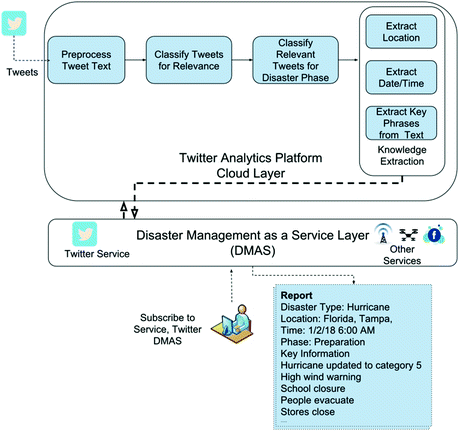

* The scope of this project lies mostly within the first two blocks of the Twitter Analytics Platform (i.e. Preprocess Tweet Text & Classify Tweets for Relevance). The output of the models (classification results of the given Tweets) will be used as input for the third block (Classify Relevant Tweets for Disaster Phase).

### 1.2 How should you frame this problem?

* It is categorized as a Supervised, Batch, Model-based Learning Problem.

### 1.3 How should performance be measured?

* The F-Beta-Score will be used to evaluate the performance of the models.

* The F-Beta-Score weighs recall more than precision by a factor of *Beta*.

* In this project *Beta* will be set smaller than 1, as precision is more important than recall in the previous diagram.

### 1.4 What would be the minimum performance needed to reach the business objective?

### 1.5 List all of the assumptions made in the project

### 1.6 Import third party resources

In [ ]:
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sns
import string
import re

In [ ]:
import nltk
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')
import nltk.tokenize
from nltk.corpus import stopwords, wordnet
from nltk.stem import WordNetLemmatizer
from nltk.util import ngrams

In [ ]:
STOPWORDS=set(stopwords.words('english'))

In [ ]:
import spacy
# !python -m spacy download en_core_web_sm
import en_core_web_sm

<a id='2'></a>
<a href='#0'>Back to ToC</a>

---
## 2. Get the Data

### 2.1 Find and document where to get the data

* The dataset used in this Notebook was created by the company *figure-eight* and was made widely known to the public by *Kaggle*, who uses it as training and test sets for their Getting Started Prediction Competition "Natural Language Processing with Disaster Tweets".

* Link to the *Kaggle* training and test datasets as well as their description can be found [here](https://www.kaggle.com/c/nlp-getting-started/data).

* Note that the *Kaggle* test set ```test.csv``` was not labeled. The labeling of the test set was done manually by the creators of this Notebook and saved separately in the file ```labeled_test.csv```.

### 2.2 Get and take a quick look at the data

In [ ]:
# Read the datasets into DataFrames
train_df = pd.read_csv('train.csv',sep=",", header="infer")
test_df = pd.read_csv('test.csv',sep=",", header="infer")
labeled_test_df = pd.read_csv('labeled_test.csv',sep=",", header="infer")

Data Format Description:
* **id** - a unique identifier for each tweet
* **text** - the text of the tweet
* **location** - the location the tweet was sent from (may be blank)
* **keyword** - a particular keyword from the tweet (may be blank)
* **target** - this denotes whether a tweet is about a real disaster (1) or not (0)

In [ ]:
# Print a concise summary of the training set
train_df.info()

In [ ]:
# Print a concise summary of the unlabeled test set
test_df.info()

In [ ]:
# Print a concise summary of the labeled test set
labeled_test_df.info()

In [ ]:
# Calculate the number and the proportion of Disaster Tweets and Non-Disaster Tweets in the training set
train_class_distrb = train_df["target"].value_counts()
print(train_class_distrb)
print(train_class_distrb/len(train_df))

# Visualize the results found
fig, axes = plt.subplots(ncols=2, nrows=1, figsize=(18, 6))
sns.barplot(x=train_class_distrb.index, y=train_class_distrb, ax=axes[0])
axes[0].set_ylabel('#Tweets')
axes[1].pie(train_class_distrb,
            labels=['Non-Disaster', 'Disaster'],
            autopct='%1.2f%%',
            explode=(0.03, 0),
            startangle=90)
fig.suptitle('Class Distribution of the Tweets (training set)', fontsize=16)
plt.show()

In [ ]:
# Calculate the number and the proportion of Disaster Tweets and Non-Disaster Tweets in the labeled test set
labeled_test_class_distrb = labeled_test_df["target"].value_counts()
print(labeled_test_class_distrb)
print(labeled_test_class_distrb/len(labeled_test_df))

# Visualize the results found
fig, axes = plt.subplots(ncols=2, nrows=1, figsize=(18, 6))
sns.barplot(x=labeled_test_class_distrb.index, y=labeled_test_class_distrb, ax=axes[0])
axes[0].set_ylabel('#Tweets')
axes[1].pie(labeled_test_class_distrb,
            labels=['Non-Disaster', 'Disaster'],
            autopct='%1.2f%%',
            explode=(0.03, 0),
            startangle=90)
fig.suptitle('Class Distribution of the Tweets (labeled test set)', fontsize=16)
plt.show()

<a id='3'></a>
<a href='#0'>Back to ToC</a>

---
## 3. Explore the Data

### 3.1 Create a copy of the data for exploration

In [ ]:
# EDA stands for Exploratory Data Analysis
eda_train = train_df.copy()

### 3.2 Identify features of interest

* Features that may yield valuable information **BEFORE** Data Preprocessing:
  * URL count per Tweet
  * Punctuation count per Tweet
  * Hashtag count per Tweet
  * Mention count per Tweet
  * Most common Hashtags
  * Most common Keywords
  * Most common Locations
  * Most common Named Entity Types
  

* Features that may yield valuable information **AFTER** Data Preprocessing:
  * Character count per Tweet
  * Word count per Tweet
  * Unique word count per Tweet
  * Average word length per Tweet
  * Most common Unigrams
  * Most common Bigrams
  * Most common Trigrams

### 3.3 Examine listed features and document findings

In [ ]:
def plot_count_histogram_of(feature, df):
    """
    A function that draws histograms to compare counts of the given feature per Non-Disaster- and per Disaster Tweet
    """
    
    # Get Non-Disaster & Disaster Tweets from the given DataFrame
    df_no = df[df["target"]==0]
    df_yes = df[df["target"]==1]
    
    # Draw count histograms for both Tweet classes, in which the x-Axis depicts the given feature
    fig, axes = plt.subplots(ncols=2, nrows=1, figsize=(18, 6), sharey=True, sharex=True)
    sns.histplot(data=df_no, x=feature, ax=axes[0], color='steelblue')
    sns.histplot(data=df_yes, x=feature, ax=axes[1], color='darkorange')
    
    # Set layout and labels of the drawn histograms
    axes[0].set_ylabel('#Tweets')
    axes[0].set_xlabel(feature + " per Tweet")
    axes[0].set_title('Non-Disaster Tweets')
    axes[1].set_xlabel(feature + " per Tweet")
    axes[1].set_title('Disaster Tweets')
    fig.suptitle(feature + ' per Tweet', fontsize=20)
    fig.tight_layout()

In [ ]:
def get_N_most_common_(feature, df, target, N):
    """
    A function that:
    - takes a target (1 or 0), a DataFrame, one of its features, and an integer 'N'
    - calculates the frequency distribution of words (elements) in that feature, not taking stopwords into consideration 
    - returns the 'N' most common words (elements) in that feature
    """
    
    if (feature == "hashtag") or (feature == 'named entity type'):
        txt = df[df['target']==target][feature].str.lower().str.replace(r'\|', ' ', regex=True).str.cat(sep=' ')
        words = nltk.tokenize.word_tokenize(txt)
        words_except_stop_dist = nltk.FreqDist(w for w in words if (w not in STOPWORDS) and (w is not None) and (w != ','))
    else:
        words = df[df['target']==target][feature].str.lower().str.replace('%20', ' ').astype(str)
        words_except_stop_dist = nltk.FreqDist(w for w in words if (w not in STOPWORDS) and (w != "nan"))
         
    result = pd.DataFrame(words_except_stop_dist.most_common(N), columns=[feature, 'Frequency'])
    return result

In [ ]:
def plot_N_most_common_(feature, df, N):
    """
    A function that draws plots showing the most common elements of the given feature in Non-Disaster & Disaster Tweets
    """
    
    # Get the most common elements of the given feature in Non-Disaster & Disaster Tweets
    df_no = get_N_most_common_(feature, df, 0, N)
    df_yes = get_N_most_common_(feature, df, 1, N)
    
    # Draw plots showing the most common elements of the given feature in Non-Disaster & Disaster Tweets
    fig, axes = plt.subplots(ncols=2, nrows=1, figsize=(20, 8), sharex=True)
    sns.barplot(x=df_no.iloc[:,1], y=df_no.iloc[:,0], ax=axes[0], color='steelblue')
    sns.barplot(x=df_yes.iloc[:,1], y=df_yes.iloc[:,0], ax=axes[1], color='darkorange')
    
    # Set layout and labels of the drawn histograms
    axes[0].set_ylabel('Most common ' + feature)
    axes[0].set_xlabel("Count")
    axes[0].set_title('Non-Disaster Tweets')
    axes[1].set_ylabel('Most common ' + feature)
    axes[1].set_xlabel("Count")
    axes[1].set_title('Disaster Tweets')
    fig.suptitle("The " + str(N) + ' most common ' + feature +"s", fontsize=20)
    fig.tight_layout()
    
    # Add legends in case of the feature 'named entity type'
    if feature == 'named entity type':
        patch1 = mpatches.Patch(label='PERSON : People, including fictional')
        patch2 = mpatches.Patch(label='ORG : Companies, agencies, institutions, etc.')
        patch3 = mpatches.Patch(label='CARDINAL : Numerals that dont fall under another type.')
        patch4 = mpatches.Patch(label='GPE : Countries, cities, states.')
        patch5 = mpatches.Patch(label='NORP : Nationalities or religious or political groups.')
        patch6 = mpatches.Patch(label='TIME : Times smaller than a day.')
        patch7 = mpatches.Patch(label='QUANTITY : Measurements, as of weight or distance.')
        patch8 = mpatches.Patch(label='ORDINAL : “first”, “second”, etc.')
        patch9 = mpatches.Patch(label='LOC : Non-GPE locations, mountain ranges, bodies of water.')
        patch10 = mpatches.Patch(label='FAC : Buildings, airports, highways, bridges, etc.')
        patch11 = mpatches.Patch(label='PRODUCT : Objects, vehicles, foods, etc. (Not services.)')
        patch12 = mpatches.Patch(label='EVENT : Named hurricanes, battles, wars, sports events, etc.')
        patch13 = mpatches.Patch(label='LANGUAGE : Any named language.')
        patch14 = mpatches.Patch(label='PERCENT : Percentage, including ”%“.')
        patch15 = mpatches.Patch(label='DATE : Absolute or relative dates or periods.')
        
        plt.legend(handles=[patch1, patch2, patch3, patch4, patch5, patch6, patch7, patch8, patch9, patch10, patch11, patch12, patch13, patch14, patch15],
                   bbox_to_anchor=(1.05, 0.85), 
                   loc='upper left', 
                   borderaxespad=0.)

        plt.show()

#### URL count per Tweet

* The feature "URL count per Tweet" is not a good discriminator for the given classification task, as there is no recognizable pattern in this feature to differentiate between Disaster and Non-Disaster Tweets.
* The URLs in each Tweet can now be safely removed.

In [ ]:
# Calculate the number of URL in each Tweet
eda_train['URL count'] = eda_train['text'].apply(lambda x: len([word for word in str(x).lower().split(" ") if 'http://' in word or 'https://' in word]))

In [ ]:
plot_count_histogram_of('URL count', eda_train)

#### Punctuation count per Tweet

* The feature "Punctuation count per Tweet" is not a good discriminator for the given classification task, as there is no recognizable pattern in this feature to differentiate between Disaster and Non-Disaster Tweets. 
* The punctuation marks in each Tweet can now be safely removed.

In [ ]:
string.punctuation

In [ ]:
# Calculate the number of punctuation in each Tweet
eda_train['Punctuation count'] = eda_train['text'].apply(lambda x: len([char for char in str(x) if char in string.punctuation]))

In [ ]:
plot_count_histogram_of('Punctuation count', eda_train)

#### Hashtag count per Tweet

* The feature "Hashtag count per Tweet" is not a good discriminator for the given classification task, as there is no recognizable pattern in this feature to differentiate between Disaster and Non-Disaster Tweets. 
* However, the hashtag contents can still be used for further data analysis. Because of this, the hashtags in each Tweet should not be removed.
* To get hashtag contents, a necessary transformation is to remove the punctuation mark '#' in the Tweet text.

In [ ]:
# Calculate the number of hashtag in each Tweet
eda_train['Hashtag count'] = eda_train['text'].apply(lambda x: len([char for char in str(x) if char == "#"]))

In [ ]:
plot_count_histogram_of('Hashtag count', eda_train)

#### Mention count per Tweet

* The feature "Mention count per Tweet" is not a good discriminator for the given classification task, as there is no recognizable pattern in this feature to differentiate between Disaster and Non-Disaster Tweets. 
* However, the mentioned entities can still contribute to further data analysis. Because of this, the mentions in each Tweet should not be removed.
* To get mentioned entities, a necessary transformation is to remove the punctuation mark '@' in the Tweet text.

In [ ]:
# Calculate the number of mention in each Tweet
eda_train['Mention count'] = eda_train['text'].apply(lambda x: len([char for char in str(x) if char == "@"]))

In [ ]:
plot_count_histogram_of('Mention count', eda_train)

#### Most common Hashtags

* The feature 'Most common Hashtags' is an acceptable discriminator for the given classification task. Half of the most common hashtags appearing in Disaster Tweets are directly linked to the disasters reported (e.g. earthquake, isis, abstorm, disaster, wildfire, terrorism). Meanwhile, the most common hashtags in Non-Disaster Tweets point out immediately that there is no disaster involved (e.g. best, fashion, edm, dubsteb, trapmusic, dance).
* However, there are many hashtags in common between the two Tweet classes, especially those suggesting news postings/publishing (i.e. nowplaying, news, breaking, worldnews). These would most likely reduce the performance of classifiers used later.
* Still, it is highly recommended to include this feature in the given classification task.

In [ ]:
def find_hashtags(tweet):
    """
    A function that returns all hashtags in the given Tweet
    """
    
    # Regex for Tweet Hashtag can be found here: https://stackoverflow.com/a/54147208
    return ", ".join([match.group(0)[1:] for match in re.finditer(r"\B#\w*[a-zA-Z]+\w*", tweet)]) or None

In [ ]:
# Find the hashtags in each Tweet
eda_train['hashtag'] = eda_train["text"].apply(lambda x: find_hashtags(x))

In [ ]:
plot_N_most_common_("hashtag", eda_train, 20)

#### Most common Keywords

* The feature 'Most common Keywords' is not a good discriminator for the given classification task, as the most common keywords in Non-Disaster Tweets highly suggest that there are disasters involved, which is not true.
* It is therefore recommended to exclude this feature from the given classification task.

In [ ]:
plot_N_most_common_("keyword", eda_train, 20)

#### Most common Locations

* The feature 'Most common Locations' is not a good discriminator for the given classification task. No clear patterns can be used to properly distinguish between the two Tweet classes.
* It is therefore recommended to exclude this feature from the given classification task.

In [ ]:
plot_N_most_common_("location", eda_train, 20)

#### Most common Named Entity Types
* The feature 'Most common Named Entity Types' is not a good discriminator for the given classification task. No clear patterns can be used to properly distinguish between the two Tweet classes.
* It is therefore recommended to exclude this feature from the given classification task.

In [ ]:
# load the english pipeline
nlp = en_core_web_sm.load()

In [ ]:
def get_named_entity_types(text):
    """
    A function that takes a Tweet text and returns a list of named entity types contained in that text
    """
    
    doc = nlp(text)
    return [X.label_ for X in doc.ents]

In [ ]:
def list2str(list):
    """
    A function that converts a list of strings into a single string, separating the old strings by commas
    """
    
    return ', '.join(list)

In [ ]:
# Find the named entity types in each Tweet
eda_train['named entity type'] = eda_train['text'].apply(get_named_entity_types).apply(list2str)

In [ ]:
plot_N_most_common_("named entity type", eda_train, 20)

### 3.4 Identify promising transformations to apply

* Clean the Tweet base texts
  * Remove URLs
  * Remove HTML tags
  * Remove emojis
  * Remove punctuation marks
* Tokenize cleaned texts
* Lowercase cleaned tokenized texts
* Remove stopwords
* Apply Part-of-Speech tagging
* Convert POS tags to Wordnet format
* Apply Wordnet lemmatizer

<a id='4'></a>
<a href='#0'>Back to ToC</a>

---
## 4. Prepare the Data

Overview:
* Copying Data (4.0)
* Data Preprocessing
  * Write functions for all data transformations that will be applied (4.1 - 4.7)
  * Apply written transformation functions (4.8)
* Post-Data-Preprocessing Analysis (4.9)

### 4.0 Make copies of the data

In [ ]:
# DPP stands for Data PreProcessing
dpp_train = train_df.copy()
dpp_test = test_df.copy()

### 4.1 Clean the Tweet base texts

In [ ]:
def remove_URL(text, decided_to_remove=True):
    """
    A function that removes URLs from the given text
    """
    
    if decided_to_remove:
        url = re.compile(r'https?://\S+|www\.\S+')
        return url.sub(r'', text)
    else:
        return text

In [ ]:
def remove_html(text, decided_to_remove=True):
    """
    A function that removes HTML tags from the given text
    """
    
    if decided_to_remove:
        html = re.compile(r'<.*?>|&([a-z0-9]+|#[0-9]{1,6}|#x[0-9a-f]{1,6});')
        return html.sub(r'',text)
    else:
        return text

In [ ]:
def remove_emoji(text, decided_to_remove=True):
    """
    A function that removes Emojis from the given text
    """
    
    if decided_to_remove:
        # Reference : https://gist.github.com/slowkow/7a7f61f495e3dbb7e3d767f97bd7304b
        emoji_pattern = re.compile(pattern = "["
                                   u"\U0001F600-\U0001F64F"  # emoticons
                                   u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                                   u"\U0001F680-\U0001F6FF"  # transport & map symbols
                                   u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                                   u"\U00002500-\U00002BEF"  # chinese char
                                   u"\U00002702-\U000027B0"
                                   u"\U00002702-\U000027B0"
                                   u"\U000024C2-\U0001F251"
                                   u"\U0001f926-\U0001f937"
                                   u"\U00010000-\U0010ffff"
                                   u"\u2640-\u2642"
                                   u"\u2600-\u2B55"
                                   u"\u200d"
                                   u"\u23cf"
                                   u"\u23e9"
                                   u"\u231a"
                                   u"\ufe0f"  # dingbats
                                   u"\u3030"
                                   "]+", flags=re.UNICODE)
        return emoji_pattern.sub(r'', text)
    else:
        return text

In [ ]:
def remove_punct(text, decided_to_remove=True):
    """
    A function that removes punctuation marks from the given text
    """
    
    if decided_to_remove:
        table = str.maketrans('', '', string.punctuation)
        return text.translate(table)
    else:
        return text

### 4.2 Tokenize cleaned texts

* The function ```word_tokenize()``` imported from the module ```nltk.tokenize``` will be used to tokenize cleaned texts.
* The returned result of ```word_tokenize()``` applied on a Tweet text is a *list of word tokens*.

In [ ]:
from nltk.tokenize import word_tokenize

### 4.3 Lowercase cleaned tokenized texts

In [ ]:
def lowercase(token_list, decided_to_lower=True):
    """
    A function that lowercases all tokens in the given token list
    """
    
    if decided_to_lower:
        return [token.lower() for token in token_list]
    else:
        return token_list

### 4.4 Remove stopwords

In [ ]:
def remove_stopwords(token_list, decided_to_remove=True):
    """
    A function that removes stopwords from the given token list
    """
    
    if decided_to_remove:
        return [token for token in token_list if token not in STOPWORDS]
    else:
        return token_list        

### 4.5 Apply Part-of-Speech tagging

* The function ```pos_tag()``` imported from the module ```nltk.tag``` will be used to apply POS tagging.
* The returned result of ```pos_tag()``` applied on a Tweet text is a *list of tuples*. Each tuple contains a token and its associated POS tag.
* The meaning of each POS tag can be found [here](https://www.ling.upenn.edu/courses/Fall_2003/ling001/penn_treebank_pos.html):

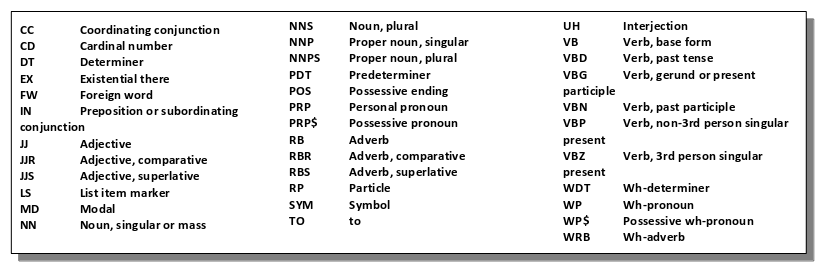

In [ ]:
from nltk.tag import pos_tag

### 4.6 Convert POS tags to Wordnet format

In [ ]:
def convert_to_wordnet(tag):
    """
    A function that converts the given (Penn Treebank) POS tag into Wordnet format
    """
        
    if tag.startswith('J'):
        return wordnet.ADJ
    elif tag.startswith('V'):
        return wordnet.VERB
    elif tag.startswith('N'):
        return wordnet.NOUN
    elif tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN

In [ ]:
def convert_POS_tags(tuple_list, decided_to_convert=True):
    """
    A function that converts all (Penn Treebank) POS tags of the given tuple list into Wordnet format
    """
        
    if decided_to_convert:
        return [(token, convert_to_wordnet(pos_tag)) for (token, pos_tag) in tuple_list]
    else:
        return tuple_list        

### 4.7 Apply Wordnet lemmatizer

In [ ]:
def lemmatize_using_wordnet(tuple_list, decided_to_lemmatize=True):
    """
    A functions that lemmatizes all tokens in the given tuple list using its associated tag and Wordnet lemmatizer
    """
    
    wnl = WordNetLemmatizer()
    if decided_to_lemmatize:
        return [wnl.lemmatize(token, tag) for token, tag in tuple_list]
    else:
        return tuple_list

### 4.8 Apply transformation functions

In [ ]:
def preprocess(df):
    """
    A function that applies all of the transformations declared above to the given DataFrame and returns it
    """
    
    # Clean the Tweet base texts
    df['text_clean'] = df['text'].apply(lambda text: remove_URL(text))
    df['text_clean'] = df['text_clean'].apply(lambda text: remove_emoji(text))
    df['text_clean'] = df['text_clean'].apply(lambda text: remove_html(text))
    df['text_clean'] = df['text_clean'].apply(lambda text: remove_punct(text))
    
    # Tokenize cleaned texts
    df['tokenized'] = df['text_clean'].apply(word_tokenize)
    
    # Lowercase cleaned tokenized texts
    df['lower'] = df['tokenized'].apply(lowercase)
    
    # Remove stopwords
    df['stopwords_removed'] = df['lower'].apply(remove_stopwords)
    
    # Apply Part-of-Speech tagging
    df['pos_tags'] = df['stopwords_removed'].apply(pos_tag)
    
    # Convert POS tags to Wordnet format
    df['wordnet_pos'] = df['pos_tags'].apply(convert_POS_tags)
    
    # Apply Wordnet lemmatizer
    df['lemmatized'] = df['wordnet_pos'].apply(lemmatize_using_wordnet)
    
    # Minor transformations for later convenience
    df['lemmatized'] = df['lemmatized'].apply(remove_stopwords)
    df['lemma_str'] = [' '.join(map(str, l)) for l in df['lemmatized']]
    
    return df

In [ ]:
# Preprocess the training data

preprocessed_train = preprocess(dpp_train)
display(preprocessed_train)

In [ ]:
# Preprocess the test data

preprocessed_test = preprocess(dpp_test)
display(preprocessed_test)

### 4.9 Analyze preprocessed data

#### A

* Comment 1
* Comment 2

#### A

* Comment 1
* Comment 2

#### A

* Comment 1
* Comment 2

#### A

* Comment 1
* Comment 2

#### A

* Comment 1
* Comment 2

#### A

* Comment 1
* Comment 2

#### A

* Comment 1
* Comment 2

#### A

* Comment 1
* Comment 2

<a id='5'></a>
<a href='#0'>Back to ToC</a>

---
## 5. Short-List Promising Models

### 5.1 Train many quick and dirty models from different categories (e.g. linear, naive Bayer, SVM, Random Forest, neural net, etc.) using different parameters

### 5.2 Measure and compare their performance

For each model, use N-fold cross validation and compute the mean and standard deviation of the performance measured on the N folds

### 5.3 Analyze the most significant variables for each algorithm

### 5.4 Analyze the type of errors the models make

### 5.5 Have a quick round of feature selection and engineering

### 5.6 Have one or two more quick iterations of the five previous steps

### 5.7 Short-list the top three to five most promising models, preferring models that make differrent types of errorss

<a id='6'></a>
<a href='#0'>Back to ToC</a>

## 6. Fine-Tune the System

### 6.1 Fine-tune the hyperparameters using cross-validation

* Treat your data transformation choices as hyperparameters, especially when you are not sure about them
* Unless there are very few hyperparameter values to explore, prefer random search over grid search

### 6.2 Try Ensemble methods. 

Combining your best models will often perform better than running them individually

### 6.3 Once you are confident about your final model, measure its performance on the test set to estimate the generalization error

Do NOT tweak your model after measuring the generalization error due to risk of overfitting the test set

<a id='7'></a>
<a href='#0'>Back to ToC</a>

## 7. Present the Solution

### 7.1 Document what you have done

### 7.2 Create a nice presentation

Highlight the big picture first

### 7.3 Explain why your solution achieves the business objective

### 7.4 Present interesting points along the ways

* Describe what worked and what did not
* List your assumptions and your system's limitations

### 7.5 Ensure your key findings are communicated through beautiful visualizations or easy-to-remember statements

<a id='8'></a>
<a href='#0'>Back to ToC</a>

## 8. Launch!